## Technique to convert numerical into categorical values:
    - Discretization (Binning)
    - Binarization
    
### 1. Discretization (Binnig)
    Discretization is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable’s values. Discretization is also called binning, where bin is an alternative name for interval.
    
        Why to use Binning?
             - To handle Outliers 
             - To improve the value spread
   
       Types of Binning
           i. Unsupervised Binning:
               - Equal Width(Uniform) Binning
               - Equal frequency (quantile) Binning
               - Kmean Binning
           ii. Supervised Binnig:
               - Decision Tree Binning
           iii. Custom Binning
   

In [1]:
#@ Importing the required libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [2]:
#@ Loading the dataset
data = pd.read_csv('titanic.csv', usecols = ['Age', 'Fare', 'Survived'])
data.dropna(inplace = True)
print(f'The shape of data is {data.shape}')
data.head()

The shape of data is (714, 3)


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


### Without applying any binning

In [3]:
#@ applying train/test/split
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.head()

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000
719,33.0,7.7750
666,25.0,13.0000


In [4]:
clf = DecisionTreeClassifier()             # creating an object
clf.fit(X_train, y_train)                  # training the model
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)       # calculating the accuracy
print(f'The accuracy score is {acc}')

The accuracy score is 0.6433566433566433


In [5]:
#@ using cross/val/score
cro_acc = np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy'))
print(f'The accuracy using cross/val/score is {cro_acc}')

The accuracy using cross/val/score is 0.6330790297339594


### applying Binning technique

In [6]:
#@ first stategy using 'quantile'
kbin_age = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')

In [7]:
#@ creating column transformer
trf = ColumnTransformer([
    ('first', kbin_age,[0]),
    ('second', kbin_fare, [1])
])

In [8]:
#@ transforming xtrain & xtest and putting into the variable
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [9]:
#@ Exploring using attributes 
trf.named_transformers_['second'].n_bins_

array([15])

In [10]:
trf.named_transformers_['second'].bin_edges_

array([array([  0.    ,   7.25  ,   7.775 ,   7.8958,   8.1583,  10.5   ,
               13.    ,  14.4542,  18.75  ,  26.    ,  26.55  ,  31.275 ,
               51.4792,  76.2917, 108.9   , 512.3292])                   ],
      dtype=object)

In [11]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

output['age_labels'] = pd.cut(x = X_train['Age'],
                             bins = trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x = X_train['Fare'],
                             bins = trf.named_transformers_['second'].bin_edges_[0].tolist())
                             
output.sample(5)                                                      
                            

,age,age_trf,fare,fare_trf,age_labels,fare_labels
360,40.0,11.0,27.9000,10.0,"(38.0, 42.0]","(26.55, 31.275]"
536,45.0,12.0,26.5500,10.0,"(42.0, 47.0]","(26.0, 26.55]"
365,30.0,8.0,7.2500,1.0,"(28.0, 30.0]","(0.0, 7.25]"
294,24.0,5.0,7.8958,3.0,"(23.0, 25.0]","(7.775, 7.896]"
503,37.0,10.0,9.5875,4.0,"(35.0, 38.0]","(8.158, 10.5]"


In [12]:
#@ Applying decisiontree after transformation
clf = DecisionTreeClassifier()
clf.fit(X_train_trf, y_train)
y_pred2 = clf.predict(X_test_trf)
acc_trf = accuracy_score(y_test, y_pred2)
print(f'The accuracy score after transformation is {acc_trf}')

The accuracy score after transformation is 0.6363636363636364


In [13]:
#@ finding cross/val/score
X_trf = trf.fit_transform(X)
(np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy')))

0.6359154929577464

0.6344679186228481


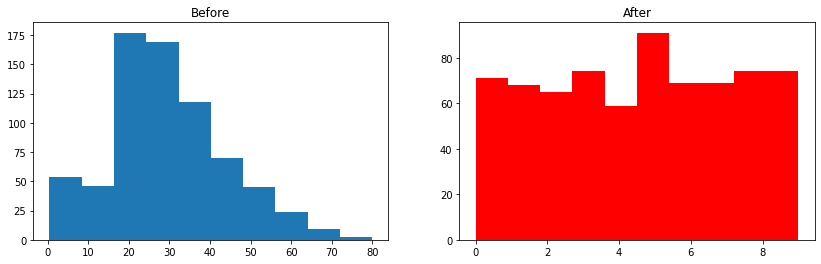

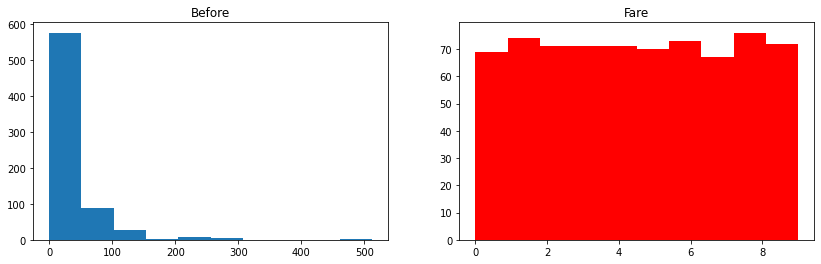

In [14]:
def discretize(bins, strategy):
    kbin_age = KBinsDiscretizer(n_bins = bins, encode = 'ordinal', strategy = strategy)
    kbin_fare = KBinsDiscretizer(n_bins = bins, encode = 'ordinal', strategy = strategy)
    
    trf = ColumnTransformer([
        ('first', kbin_age,[0]),
        ('second', kbin_fare,[1])
    ])
    
    X_trf = trf.fit_transform(X)           # training the data
    
    # checking by cross/val/score
    print(np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy')))
    
    plt.figure(figsize = (14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")
    
    plt.subplot(122)
    plt.hist(X_trf[:, 0], color = 'red')
    plt.title("After")
    plt.show()
    
    plt.figure(figsize = (14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")
    
    plt.subplot(122)
    plt.hist(X_trf[:,1], color = 'red')
    plt.title("Fare")
    plt.show()

discretize(10, 'quantile')

0.6275039123630672


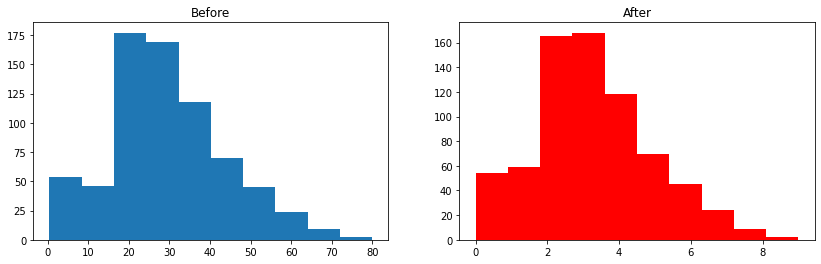

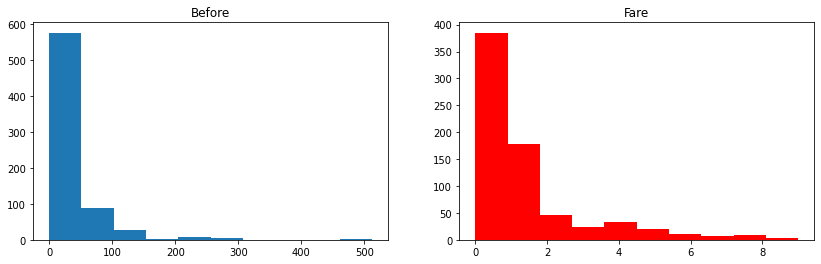

In [15]:
discretize(10, 'kmeans')

0.6289319248826291


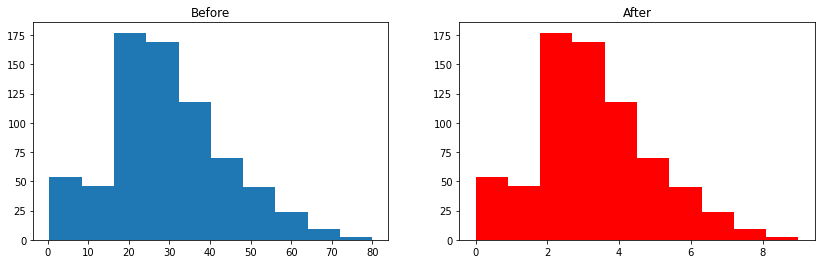

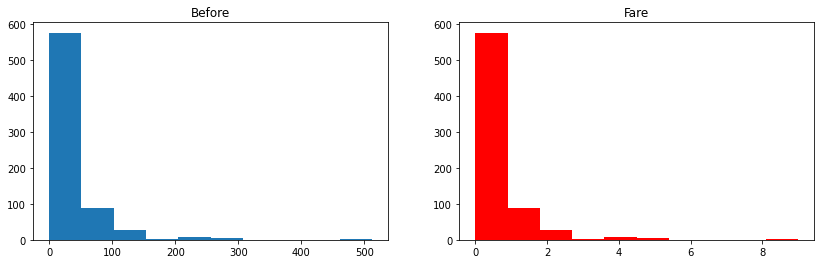

In [16]:
discretize(10, 'uniform')

## Custom/Domain Based Binning

- It is the way of making bins by using the domain knowledge.

example:

    Let, us suppose if we want to seperate the age of people the we can  seperate them according to their age like:
    {
    [0-18] = 'Kids',
    [18-60] = 'Adult',
    [60-80] = 'Old'
    }